# Processing POI data from Liverpool

## Import packages

In [76]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import utilities

## Read in POI data

In [2]:
# read the POI data
df_poi = pd.read_csv("Liverpool_hub_four_POI/poi_4565130/poi-extract-2022_03.csv", sep="|")

In [3]:
df_poi.columns

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date'],
      dtype='object')

In [4]:
df_poi_by_class = df_poi.pointx_class.value_counts().to_frame().reset_index().rename(columns={"index": "class", "pointx_class": "number"})
df_poi_by_class['class_4d'] = df_poi_by_class['class'].apply(lambda x: str(x)[-4:])

In [5]:
df_poi_by_class

,class,number,class_4d
0,10590732,536,0732
1,6340433,415,0433
2,1020034,383,0034
3,2100156,315,0156
4,1020018,247,0018
...,...,...,...
391,7420585,1,0585
392,7370464,1,0464
393,7420783,1,0783
394,9480824,1,0824


## Read in POI classifications and join the POI data with classifications

In [6]:
df_poi_class_table = pd.read_csv("Liverpool_hub_four_POI/poi_4565130/docs/POI_CLASSIFICATIONS.txt", sep = "|", dtype=object)
# .["Class Number","Classification Description"]
df_poi_class_table.columns

Index(['ID', 'Class Number', 'Classification Description',
       'Category Number Foreign Key'],
      dtype='object')

In [7]:
df_poi_by_class = pd.merge(how='left',
         left= df_poi_by_class, 
         right=df_poi_class_table, 
         left_on='class_4d', right_on='Class Number')

In [8]:
df_poi_by_class.head(50)

,class,number,class_4d,ID,Class Number,Classification Description,Category Number Foreign Key
0,10590732,536,0732,619,0732,BUS STOPS,59
1,6340433,415,0433,350,0433,ELECTRICAL FEATURES,34
2,1020034,383,0034,14,0034,"PUBS, BARS AND INNS",02
3,2100156,315,0156,118,0156,HAIR AND BEAUTY SERVICES,10
4,1020018,247,0018,10,0018,FAST FOOD AND TAKEAWAY OUTLETS,02
5,1020043,234,0043,15,0043,RESTAURANTS,02
6,3200269,231,0269,217,0269,UNSPECIFIED AND OTHER ATTRACTIONS,20
7,9470699,223,0699,536,0699,CONVENIENCE STORES AND INDEPENDENT SUPERMARKETS,47
8,1020013,215,0013,9,0013,"CAFES, SNACK BARS AND TEA ROOMS",02
9,2090141,166,0141,98,0141,CASH MACHINES,09


In [9]:
df_poi.shape
# 7693 POIs in total

(7693, 25)

## Selecting several types of POI as candidate sites for the case study

First, types of POIs used in the location-allocation analysis in Feng et al. 2021:

```
The U.S. Geological Survey maintains the National Structures Dataset that contains data on Fire/Police Stations, Hospital/Medical Centers, Ambulance Services, etc. We used this data in defining possible drone sites. Fig. 4 shows the 520 potential stations in the study area, among which the stations are selected to equip drones.

40 stations are selected to equip the drones.
```

We select the following types of POIs:
- 343|"0422"|"POLICE STATIONS"|"33"
- 337|"0414"|"FIRE BRIGADE STATIONS"|"33"
- 301|"0106"|"MEDICAL EQUIPMENT RENTAL AND LEASING"|"29"
- 302|"0356"|"AMBULANCE AND MEDICAL TRANSPORTATION SERVICES"|"29"
- 613|"0731"|"BUS AND COACH STATIONS, DEPOTS AND COMPANIES"|"57"
- 614|"0738"|"RAILWAY STATIONS, JUNCTIONS AND HALTS"|"57"
- 615|"0756"|"TRAM, METRO AND LIGHT RAILWAY STATIONS AND STOPS"|"57"
- 616|"0758"|"TAXI RANKS"|"57"
- 617|"0761"|"UNDERGROUND NETWORK STATIONS"|"57"
- 618|"0794"|"LONDON UNDERGROUND ENTRANCES"|"57"
- 247|"0293"|"GYMNASIUMS, SPORTS HALLS AND LEISURE CENTRES"|"24"
- 362|"0456"|"HALLS AND COMMUNITY CENTRES"|"34"

In [10]:
def check_number_POI(list_poi_class):
    print(df_poi[df_poi["pointx_class"].astype(str).str.contains('|'.join(list_poi_class))].shape[0])

In [11]:
# how many sites are in these types? Only 8
list_poi_class = ["0422","0414","0106","0356","0293", "0456"]

check_number_POI(list_poi_class)

93


This can be the case study: **SELECT 10 out of 93 candidate sites in the p-median problem (PMP).**

In [12]:
# visualise the map of these POIs
list_poi_class = ["0422","0414","0106","0356","0293", "0456"]
df_poi_subset = df_poi[df_poi["pointx_class"].astype(str).str.contains('|'.join(list_poi_class))]

In [13]:
print(df_poi_subset.columns)
print(df_poi_subset.shape[0])

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date'],
      dtype='object')
93


In [14]:
gdf_poi = gpd.GeoDataFrame(
    df_poi_subset, geometry=gpd.points_from_xy(df_poi_subset.feature_easting, df_poi_subset.feature_northing))
gdf_poi = gdf_poi.set_crs('epsg:27700')

In [71]:
# write gdf_poi to geojson
gdf_poi.to_file("Sites_Liverpool_hub_four.geojson")

/tmp/ipykernel_674/2847825186.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_poi.to_file("Sites_Liverpool_hub_four.geojson")


Text(0.5, 1.0, 'Candidate sites in Liverpool Hub Four (93 sites)')

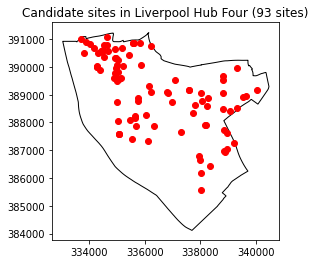

In [15]:
# plot gdf_poi
# read the boundary of Liverpool Hub Four
gdf_liverpool_hub_four = gpd.read_file("Liverpool_hub_four_neighbourhood.geojson")
ax = gdf_liverpool_hub_four.plot(color='white', edgecolor='black')
gdf_poi.plot(ax=ax, color='red')
plt.title("Candidate sites in Liverpool Hub Four (93 sites)")

## Calculate distance matrix

In [16]:
# read in street segments
gdf_street_segments = gpd.read_file("nkde_crime_Liverpool_hub_four.geojson")

In [17]:
gdf_street_segments.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [18]:
# add demand_id
gdf_street_segments["demand_id"] = np.arange(len(gdf_street_segments))
# add feature_easting and feature_northing from geometry data
gdf_street_segments["feature_easting"], gdf_street_segments["feature_northing"] = gdf_street_segments.geometry.x, gdf_street_segments.geometry.y
# transform to WGS84 
gdf_street_segments_wgs = gdf_street_segments.to_crs("epsg:4326")
gdf_street_segments["long"],gdf_street_segments["lat"] = gdf_street_segments_wgs.geometry.x, gdf_street_segments_wgs.geometry.y 

In [73]:
gdf_street_segments.to_file("nkde_crime_Liverpool_hub_four.geojson")

/tmp/ipykernel_674/4097671834.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_street_segments.to_file("nkde_crime_Liverpool_hub_four.geojson")


In [19]:
# add a column of 'site_id' to gdf_poi. get a dataframe of lat, long, easting, northing
gdf_poi["site_id"] = np.arange(len(gdf_poi))
gdf_poi_wgs = gdf_poi.to_crs("epsg:4326")
gdf_poi["long"],gdf_poi["lat"] = gdf_poi_wgs.geometry.x, gdf_poi_wgs.geometry.y 

In [74]:
# write gdf_poi to geojson
gdf_poi.to_file("Sites_Liverpool_hub_four.geojson")

/tmp/ipykernel_674/2847825186.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_poi.to_file("Sites_Liverpool_hub_four.geojson")


In [20]:
print(gdf_poi_wgs.geometry.x.head())
print(gdf_poi["long"].head())

142    -2.962925
143    -2.967434
1498   -2.915499
1505   -2.930720
2007   -2.977772
dtype: float64
142    -2.962925
143    -2.967434
1498   -2.915499
1505   -2.930720
2007   -2.977772
Name: long, dtype: float64


In [21]:
df_site = gdf_poi[["site_id", "long", "lat", "feature_easting", "feature_northing"]].rename(columns={"long":"site_long", "lat":"site_lat", "feature_easting":"site_easting", "feature_northing":"site_northing" })

In [22]:
df_demand = gdf_street_segments[["demand_id", "long", "lat", "feature_easting", "feature_northing"]].rename(columns={"long":"demand_long", "lat":"demand_lat", "feature_easting":"demand_easting", "feature_northing":"demand_northing" })

In [23]:
# cartesian product in pandas
df_distance = df_site.merge(df_demand, how='cross')
df_distance.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing'],
      dtype='object')

In [174]:
print(df_site.shape[0])
print(df_demand.shape[0])
print(df_distance.shape[0] - df_site.shape[0]*df_demand.shape[0])

93
1710
0


### Euclidean distance

In [35]:
df_distance.dtypes

site_id              int64
site_long          float64
site_lat           float64
site_easting       float64
site_northing      float64
demand_id            int64
demand_long        float64
demand_lat         float64
demand_easting     float64
demand_northing    float64
dtype: object

In [44]:
df_distance['Euclidean'] = np.sqrt(np.square(df_distance.demand_easting - df_distance.site_easting) + 
                                   np.square(df_distance.demand_northing - df_distance.site_northing))

In [45]:
# test pivot_table
df_test = df_distance.iloc[:5,]

In [46]:
print(df_test)

   site_id  site_long   site_lat  site_easting  site_northing  demand_id  \
0        0  -2.962925  53.387372      336054.0       388267.0          0   
1        0  -2.962925  53.387372      336054.0       388267.0          1   
2        0  -2.962925  53.387372      336054.0       388267.0          2   
3        0  -2.962925  53.387372      336054.0       388267.0          3   
4        0  -2.962925  53.387372      336054.0       388267.0          4   

   demand_long  demand_lat  demand_easting  demand_northing    Euclidean  
0    -2.913968   53.394703   339320.415381    389039.829352  3356.595693  
1    -2.911149   53.394078   339507.021123    388967.900086  3523.438066  
2    -2.908332   53.393448   339693.431628    388895.457235  3693.294068  
3    -2.905632   53.392676   339871.898002    388807.293089  3855.938508  
4    -2.903149   53.391663   340035.599615    388692.461849  4004.266884  


In [48]:
df_test_pivot = pd.pivot_table(df_test, values='Euclidean', index=['site_id'],
                    columns=['demand_id'], aggfunc=np.sum)

In [50]:
df_test_pivot.columns

Int64Index([0, 1, 2, 3, 4], dtype='int64', name='demand_id')

In [75]:
df_distance.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing', 'Euclidean'],
      dtype='object')

In [53]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_Euclidean = pd.pivot_table(df_distance, values='Euclidean', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.sum)

In [55]:
print(df_distance_pivot_Euclidean.index)
print(df_distance_pivot_Euclidean.columns)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709],
           dtype='int64', name='demand_id', length=1710)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92],
           dtype='int64', name='site_id')


In [57]:
# save as Euclidean_distance_site_demand.csv
file_distance_Euclidean = 'distance_matrix_demand_site_Euclidean.csv'
df_distance_pivot_Euclidean.to_csv(file_distance_Euclidean)

In [61]:
# read in this csv and transform it into an ndarray. 
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_Euclidean)
# array_distance_Eudlidean is a numpy array, with rows and columns corresponding to demands and sites, respectively

In [82]:
assert(array_distance_Eudlidean.shape == (1710, 93))

### Network distance

In [ ]:
# using OSRM

In [ ]:
df_distance['network'] = ??

In [ ]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_network = pd.pivot_table(df_distance, values='network', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.sum)

In [ ]:
print(df_distance_pivot_network.index)
print(df_distance_pivot_network.columns)

In [ ]:
# save as Euclidean_distance_site_demand.csv
file_distance_network = 'distance_matrix_demand_site_network.csv'
df_distance_pivot_network.to_csv(file_distance_network)

In [ ]:
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_network)
assert(array_distance_Eudlidean.shape == (1710, 93))

### No-drone-zone-contrained Euclidean distance

In [ ]:
# need to find package to compute

In [ ]:
df_distance['constrained'] = ??

In [ ]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_constrained = pd.pivot_table(df_distance, values='constrained', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.sum)

In [ ]:
print(df_distance_pivot_constrained.index)
print(df_distance_pivot_constrained.columns)

In [ ]:
# save as Euclidean_distance_site_demand.csv
file_distance_cons = 'distance_matrix_demand_site_constrained.csv'
df_distance_pivot_constrained.to_csv(file_distance_cons)

In [ ]:
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_cons)
assert(array_distance_Eudlidean.shape == (1710, 93))

## Save distance dataframe

In [ ]:
df_distance.to_csv('distance_dataframe.csv')